# Importing Required Libs

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [ ]:
import seaborn as sns
import matplotlib.image as immg
import gc
import numpy as np
import random
from PIL import Image
import cv2

# Train Data Read

In [ ]:
train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
train
#train csv imageid-celltype-pixeldetails in which cell is present

In [ ]:
train['file_path'] =train['id'].apply(lambda x: '../input/sartorius-cell-instance-segmentation/train/{}.png'.format(x))
train.head()
#in train csv , we have mapped the image id with image location and stored it in the df col file path

In [ ]:
#unique Images
uid = train.id.unique()
len(uid)

Annotating/Masking the training dataset using cell indecies information provided in train.csv

In [ ]:
#Masking functions
def get_image(path):
    image = np.array(Image.open(path))
    #image=cv2.imread(Image.open(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_annot(img_id):
    return train[train.id == img_id].annotation.values

def get_mask(img_annotations,colours=False): 
    if colours:
        mask = np.zeros((520, 704, 1))
        for annot in img_annotations:
            mask += rle_decode(annot, shape=(520, 704, 1))
    else:
        mask = np.zeros((520, 704, 1))
        for annot in img_annotations:
            mask += rle_decode(annot, shape=(520, 704, 1))
    mask = mask.clip(0, 1)
    return mask

In [ ]:
def rle_decode(mask_rle, shape, color=1):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [ ]:
#OriginalImage
im=np.array(Image.open('../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png'))
plt.imshow(im)

In [ ]:
#Image after BGR2RGB conversion
im2=get_image('../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png')
plt.imshow(im2)

In [ ]:
print(uid[0])

In [ ]:
ann=get_annot(uid[0])# will get the pixel(annotation) values where the cell is precent of all cells present in a image w.r.t imgID
print(len(ann))
im_mask=get_mask(ann)#will generate a mask with values from annotations
plt.imshow(im_mask)

In [ ]:
#Visualizing images and masks

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
#im=np.array(Image.open('../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png'))
plt.imshow(im)
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(im_mask)
plt.title('Mask')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
#plt.imshow(cv2.imread('./segment/0030fd0e6378.png',0))
plt.imshow(im)
plt.imshow(im_mask,alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

# 2. Preparing the data

In [ ]:
# Set some parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
X_TRAIN_PATH = '../input/sartorius-cell-instance-segmentation/train/'
X_TEST_PATH = '../input/sartorius-cell-instance-segmentation/test/'

In [ ]:
# Get trainIDs
train_ids = next(os.walk(X_TRAIN_PATH))[2]
print(len(train_ids))
print(len(uid))

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(uid), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(uid), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
print('Getting and resizing train images')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(uid), total=len(uid)):
    path = X_TRAIN_PATH + id_
    img = imread(path + '.png')[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 2)
    X_train[n] = img
    
print("done")

In [ ]:
print(len(X_train))

In [ ]:
print('Getting and resizing masks')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(uid), total=len(uid)):
    
    ann1=get_annot(uid[n])# will get the pixel(annotation) values where the cell is precent of all cells present in a image w.r.t imgID
    im_mask1=get_mask(ann)#will generate a mask with values from annotations
    mask = im_mask1[:,:,0]
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
    Y_train[n] = mask
print("done")

In [ ]:
print(len(Y_train))

In [ ]:
#Getting Test Ids
test_ids = next(os.walk(X_TEST_PATH))[2]
print(test_ids)

In [ ]:
# Get and resize test images

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    print(n, id_)
    path = '../input/sartorius-cell-instance-segmentation/test/'+id_
    img = imread(path)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 2)
    X_test[n] = img

print('Done!')

In [ ]:
sample_id_num = 15
plt.imshow(X_train[sample_id_num][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(Y_train[sample_id_num][:,:,0])
plt.show()

In [ ]:
type(X_train)
X_train.shape

In [ ]:
with open('X_train1.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('Y_train.npy', 'wb') as f:
    np.save(f, Y_train)
    
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)


In [ ]:
with open('../input/requiredcellsegmentation/X_train.npy', 'rb') as f:
    X_train = np.load(f)

with open('../input/requiredcellsegmentation/Y_train.npy', 'rb') as f:
    Y_train = np.load(f)
    
with open('../input/requiredcellsegmentation/X_test.npy', 'rb') as f:
    X_test = np.load(f)

In [ ]:
print( X_train.shape)
print( Y_train.shape)
print( X_test.shape)

No augumentation

# Training on Unet model available as examples this is the unet structure that i see in examples

In [ ]:
tf.to_int32 = lambda x: tf.cast(x, tf.int32)

def mean_iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return tf.convert_to_tensor(iou)

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def jaccard_loss(y_true, y_pred):
   
    return -jaccard_coef(y_true, y_pred)

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
# Build U-Net model
inputs = Input((256, 256, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient,mean_iou])
#model.compile(optimizer='adam', loss=jaccard_loss', metrics=[dice_coefficient,mean_iou])
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef,'accuracy'])

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('best_model_15.h5', verbose=1, save_best_only=True)
results = model.fit([X_train[0], Y_train, validation_split=0.15, batch_size=10, epochs=50, callbacks=[earlystopper, checkpointer])

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(results.history['iou_coef'])
plt.plot(results.history['val_iou_coef'])
plt.title('mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

My Unet Model

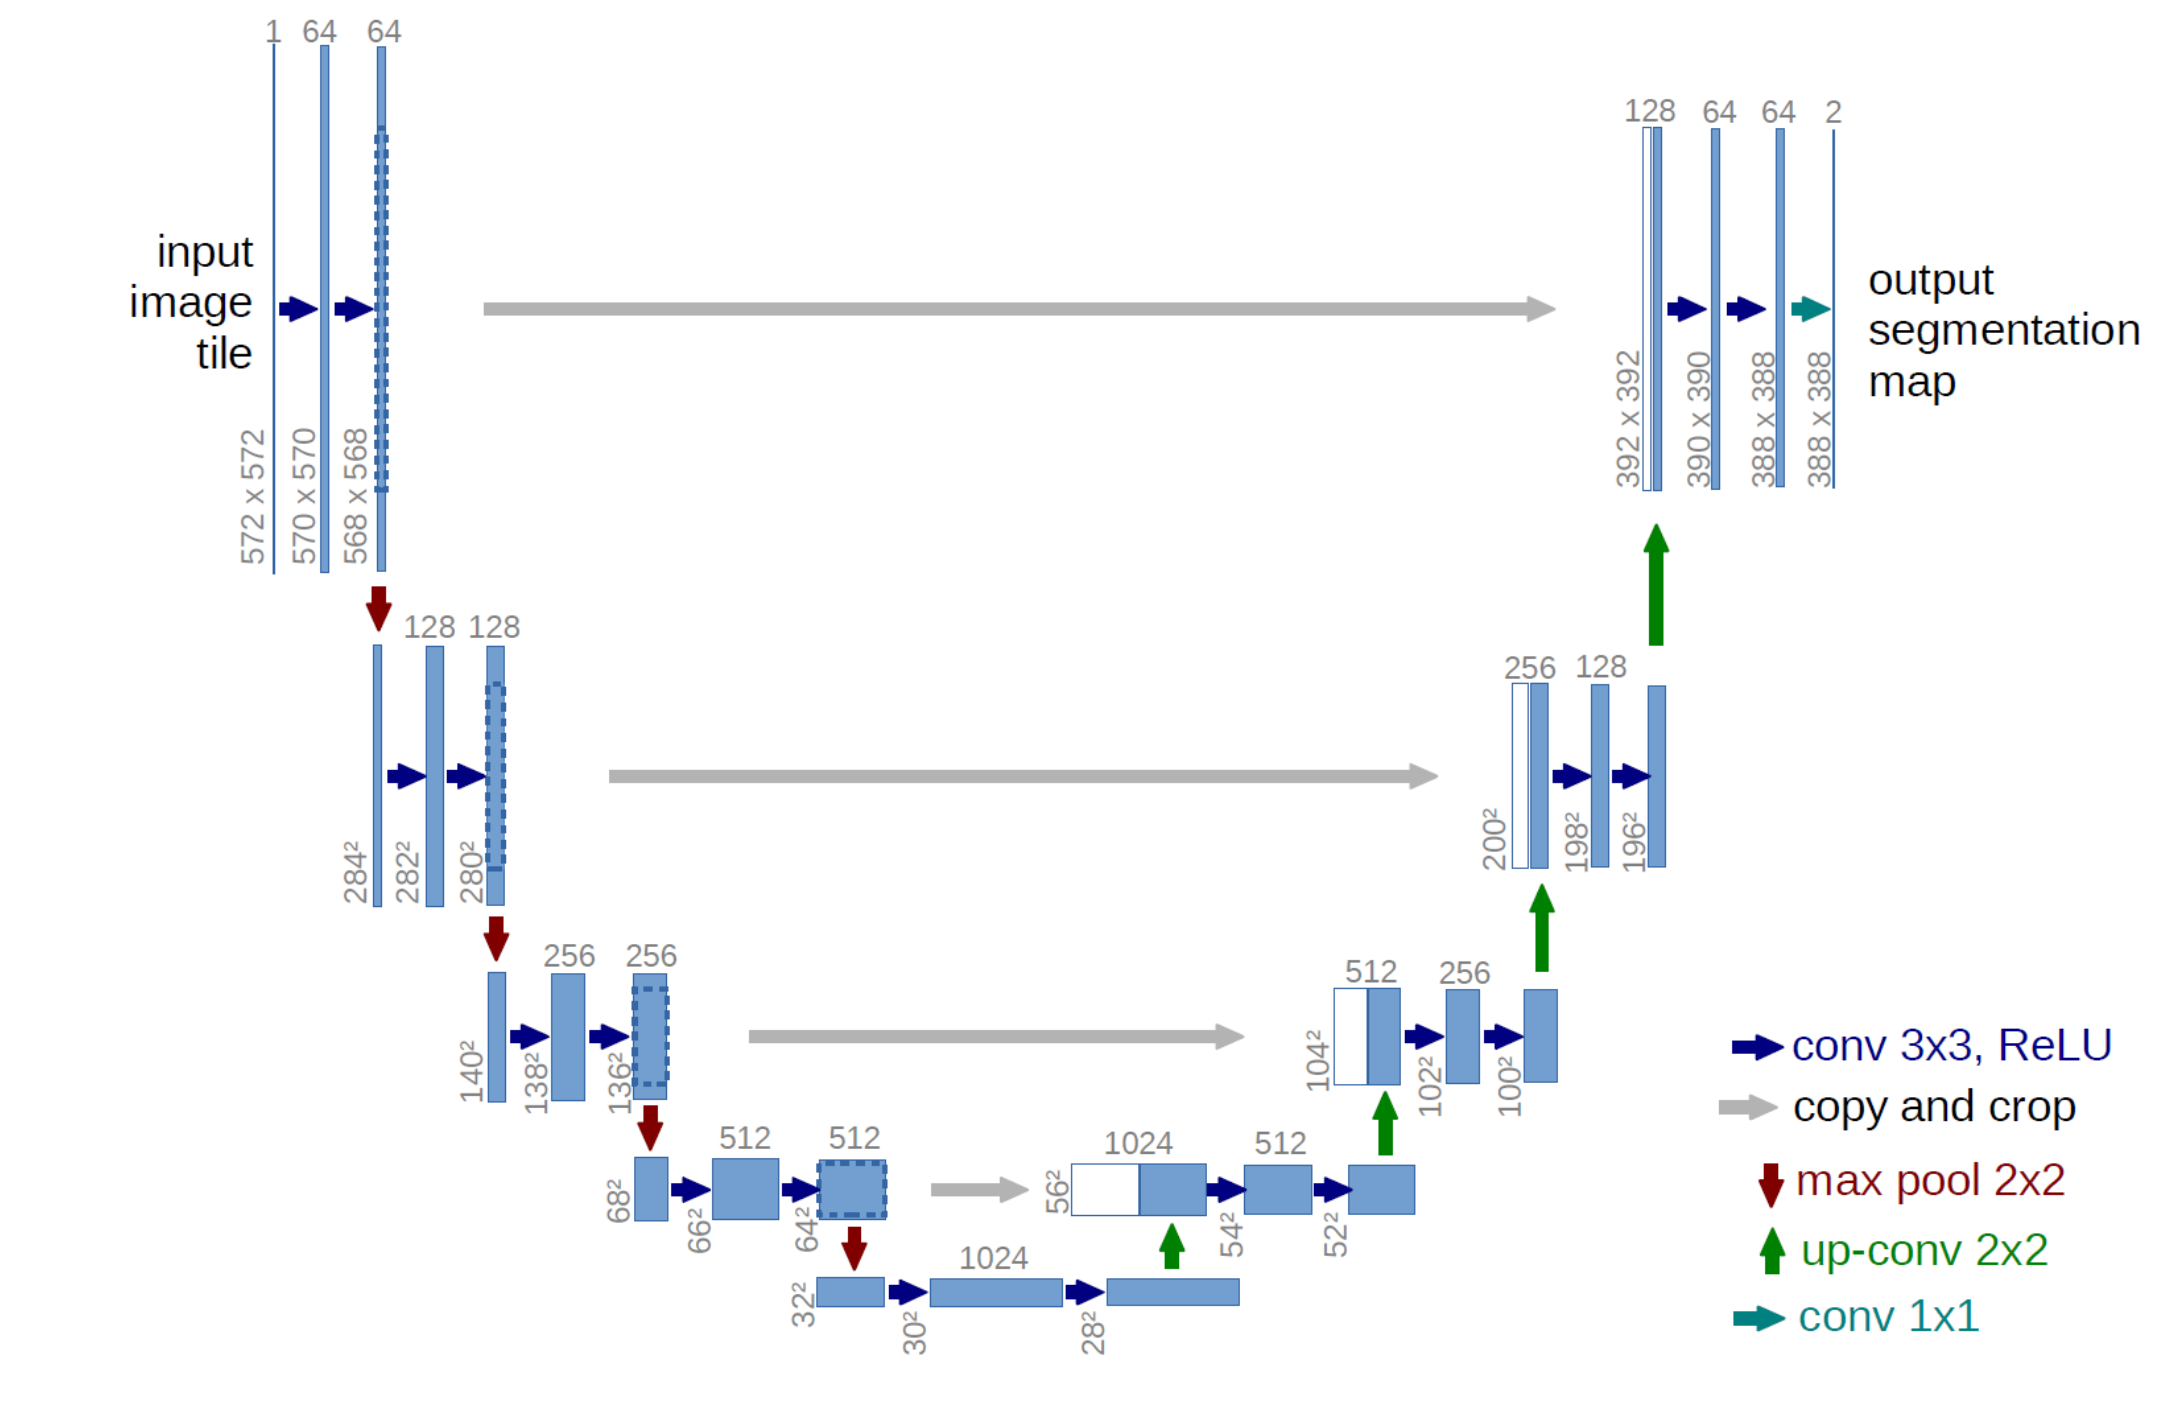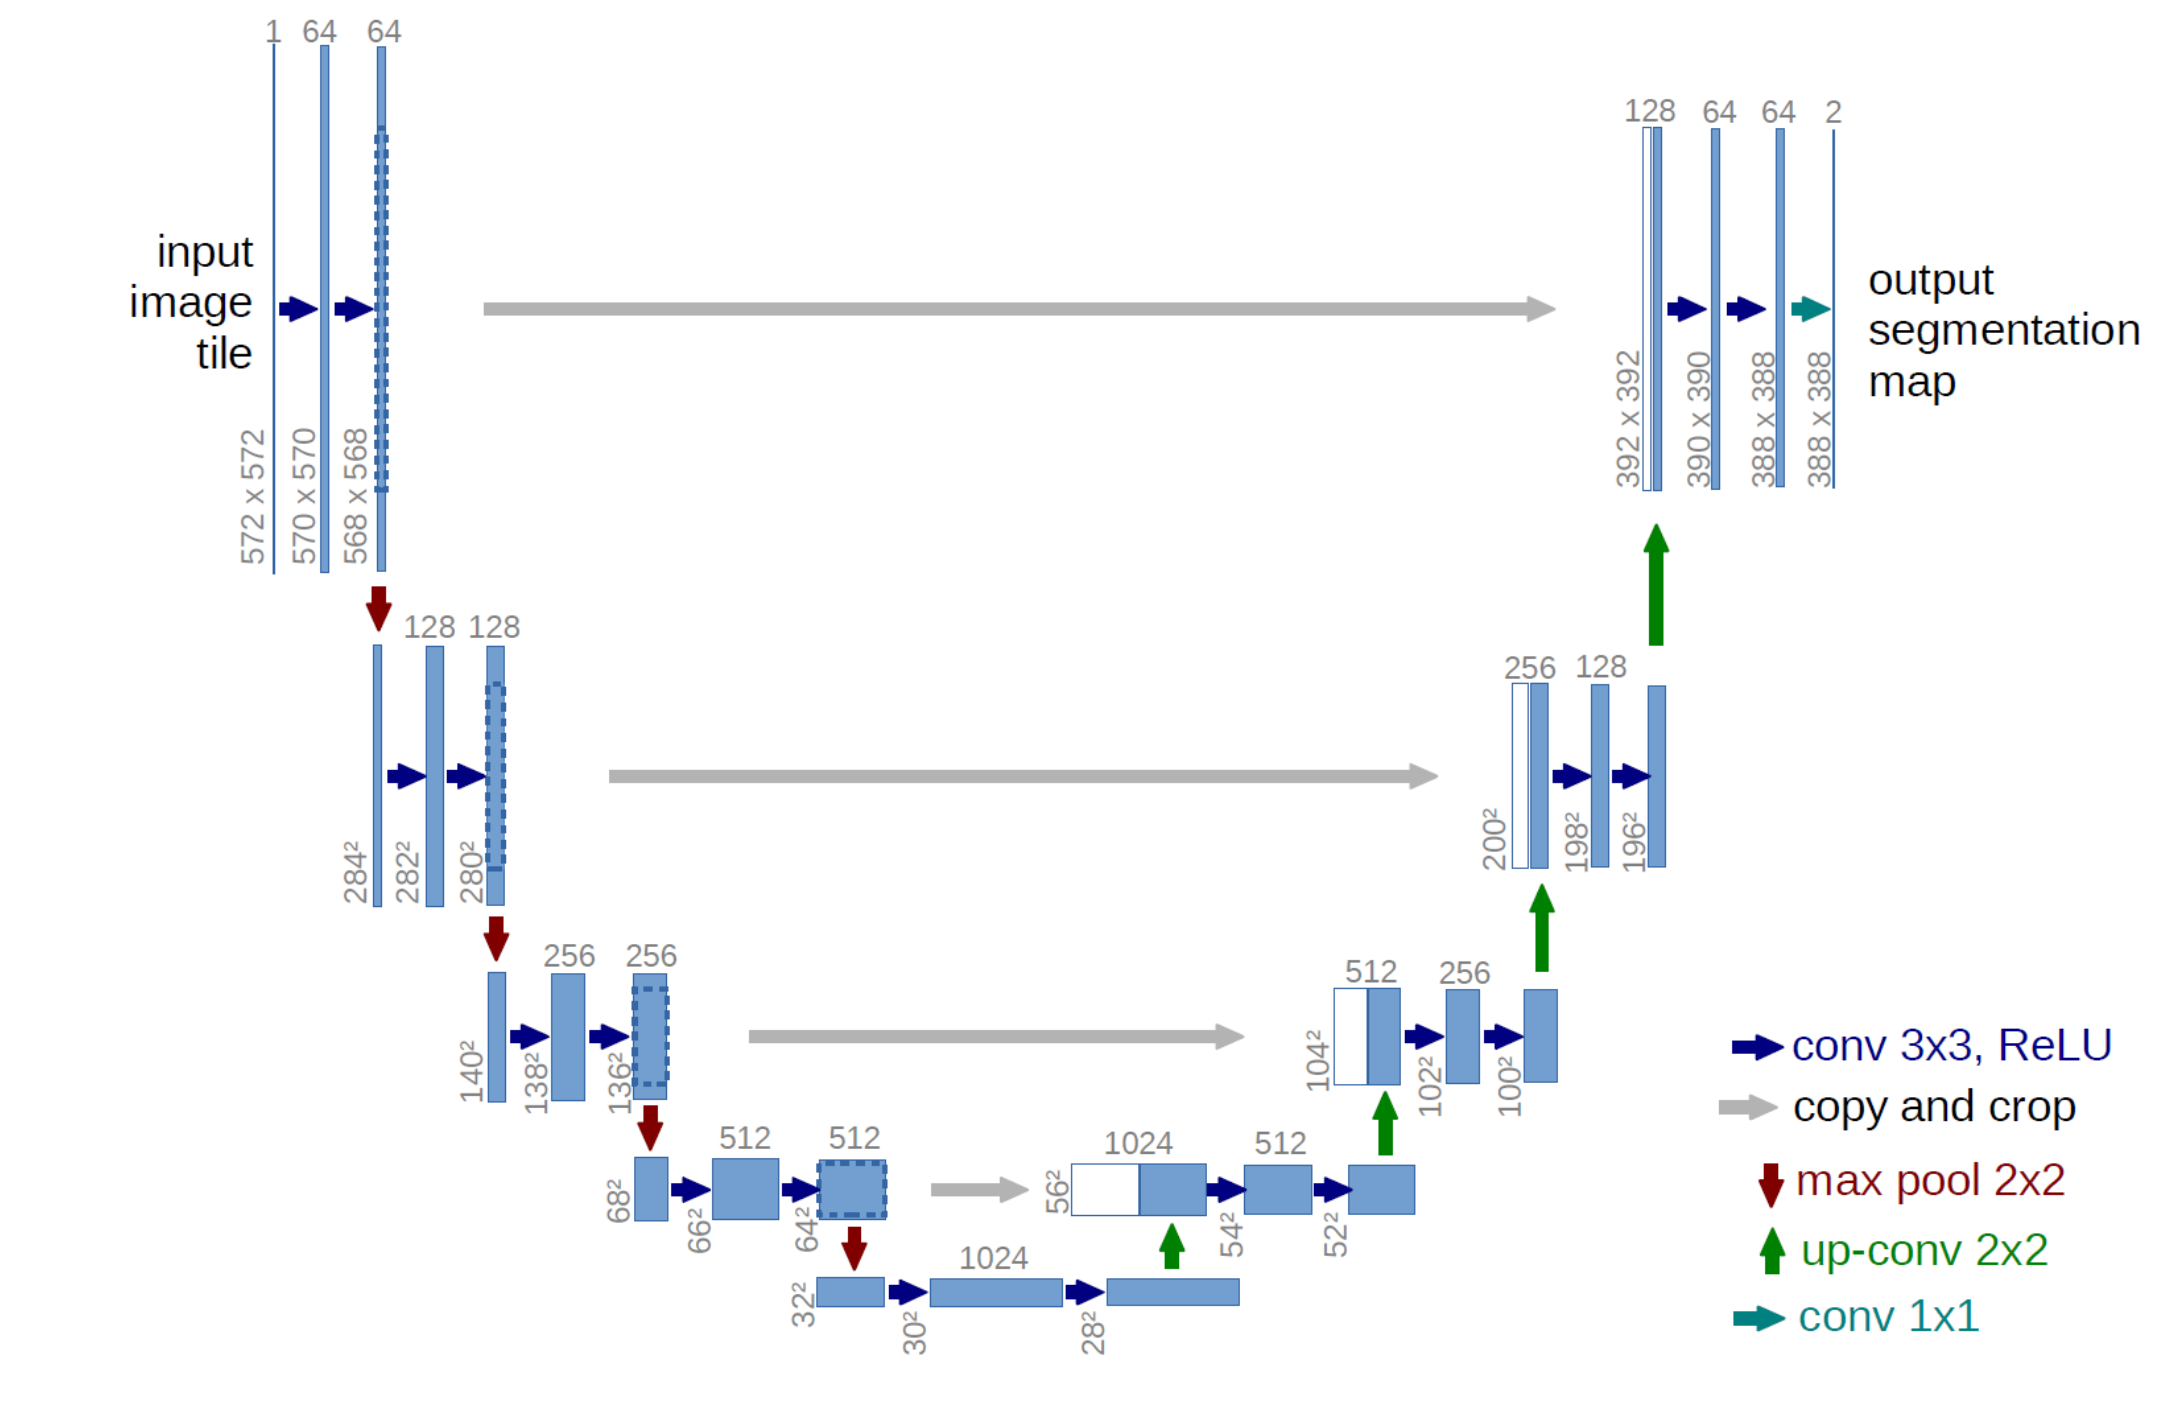

In [ ]:
X_train.shape

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.01,patience=3,verbose=1)

In [ ]:
# Building a U-Net model
#functional
inputs = Input((256, 256, 1))
la = Lambda(lambda x: x / 255) (inputs)

ec1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(la)#(None, 256, 256, 16)
ec1 = Dropout(0.1) (ec1)#layer Dropout#shape=(None, 256, 256, 16)
ec_f1 = Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same') (ec1)
ec_f1_red = MaxPooling2D((2, 2)) (ec_f1)#reduced shape=(None, 128, 128, 16)

ec2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(ec_f1_red)#shape=(None, 128, 128, 32)
ec2 = Dropout(0.1) (ec2)#layer Dropout#shape=(None, 128, 128, 132)
ec_f2 = Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same') (ec2)#shape=(None, 128, 128, 32)
ec_f2_red = MaxPooling2D((2, 2)) (ec_f2)#reduced shape=(None, 64, 64, 32)

ec3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec_f2_red)#shape=(None, 64, 64, 64)
ec3 = Dropout(0.2) (ec3)#layer Dropout#shape=(None, 64, 64, 64)
ec_f3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec3)#shape=(None, 64, 64, 64)
ec_f3_red = MaxPooling2D((2, 2)) (ec_f3)#reduced shape=(None, 32, 32, 64)

ec4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec_f3_red)#shape=(None, 32, 32, 128)
ec4 = Dropout(0.2) (ec4)#shape=(None, 32, 32, 128)
ec_f4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec4)#shape=(None, 32, 32, 128)
ec_f4_red = MaxPooling2D(pool_size=(2, 2)) (ec_f4)#shape=(None, 16, 16, 128)

ec5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec_f4_red)#shape=(None, 16, 16, 256)
ec5 = Dropout(0.3) (ec5)#shape=(None, 16, 16, 256)
ec_f5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (ec5)#shape=(None, 16, 16, 256)

duc1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (ec_f5)
dconc1 = concatenate([duc1, ec_f4])
dc1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dconc1)
dc1 = Dropout(0.2) (dc1)
dc_f1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dc1)

duc2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (dc_f1)
dconc2 = concatenate([duc2 , ec_f3])
dc2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dconc2)
dc2 = Dropout(0.2) (dc2)
dc_f2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dc2)

duc3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (dc_f2)
dconc3 = concatenate([duc3, ec_f2])
dc3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dconc3)
dc3 = Dropout(0.1) (dc3)
dc_f3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dc3)

duc4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (dc_f3)
dconc4 = concatenate([duc4, ec_f1], axis=3)
dc4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dconc4)
dc4 = Dropout(0.1) (dc4)
dc_f4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (dc4)

output2 = Conv2D(1, (1, 1), activation='sigmoid') (dc_f4)



model2 = Model(inputs=[inputs], outputs=[output2])
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=[mean_iou])
model2.summary()

In [ ]:
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('best_model_relu.h5', verbose=1, save_best_only=True)
results2 = model2.fit(X_train, Y_train, validation_split=0.15, batch_size=10, epochs=30,callbacks = [earlystopper, checkpointer])

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(results2.history['loss'])
plt.plot(results2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(results2.history['mean_iou'])
plt.plot(results2.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Viraj Unet

In [ ]:
inputs = Input((256, 256, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])


In [ ]:
model.summary()

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)
# use this for compiling
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef,'accuracy'])

In [ ]:
# Fit model
#earlystopper = EarlyStopping(patience=10, verbose=1)
#checkpointer = ModelCheckpoint('best_model_25.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=10, epochs=20)

# Predictions

In [ ]:
# Predict on train, val and test
#model = load_model('best_model.h5', custom_objects={'dice_coefficient': dice_coefficient})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (256, 256), mode='constant', preserve_range=True))

In [ ]:
preds_train
preds_train_t = (preds_train > 0.8).astype(np.uint8)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print(ix)
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(preds_train[ix])
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Test samples
ix = random.randint(0, len(preds_test_t)-1)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [ ]:
for pred in preds_test_t:
    plt.imshow(pred)
    plt.title('pred before resize')
    plt.axis("off")
    plt.show()